# Modeling

This notebook aims at analyzing two steps of the project: 

1. **SVD Training and Validation**

    - Perform a SVD recommendation using the [FunkSVD](https://github.com/gbolmier/funk-svd) algorithm. In particular, rows are users and columns are the provided offers. Values in the matrix (which would be ratings) are the mean reward obtained for each user for the associated offer. 
    
    - Analize the number of factors to use in SVD
    
    - Extracts prediction accuracy (RMSE, MAE) and usage (Precision@k, Recall@k) metrics. 

2. **Cluster Training and Validation**

    - Perform K-means clustering on the predicted utility matrix from the SVD algorithm. However, relevant users' features such as `income` are also added to the clustering training set.
    
    - Analyze the number $k$ of centroids to use based on sillhouette score


## Imports and Data Loading

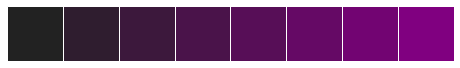

In [23]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score    
sources_path = './../sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
import utils
from funk_svd.svd import SVD
import joblib
data_dir = './../data'
plots_dir = './plots/'
progbar = utils.ProgressBar(elapsed_time=True)

palette = "purple"
second_palette = ["#60489D", "#46BB93", "#F9B74D"]
sns_palette = sns.dark_palette(palette, n_colors=8)
sns.palplot(sns_palette)
sns.set_palette(sns_palette)
sns.set(font_scale=1.2)

In [19]:
profile = pd.read_csv(os.path.join(data_dir, "profile.csv"), sep=';', usecols=["person", "income"])
profile.set_index(["person"], inplace=True)
df_matrix = pd.read_csv(os.path.join(data_dir, 'df_matrix.csv'), sep=';')

,income
person,
0610b486422d4921ae7d2bf64640c50b,112000.0
78afa995795e4d85b5d9ceeca43f5fef,100000.0
e2127556f4f64592b11af22de27a7932,70000.0
389bc3fa690240e798340f5a15918d5c,53000.0
2eeac8d8feae4a8cad5a6af0499a211d,51000.0
...,...
6d5f3a774f3d4714ab0c092238f3a1d7,54000.0
2cb4f97358b841b9a9773a7aa05a9d77,72000.0
01d26f638c274aa0b965d24cefe3183f,73000.0


## 1. SVD Training and Validation

In [4]:
df_ratings = pd.melt(df_matrix, id_vars='person').query("value != 0").reset_index(drop=True)
df_ratings.rename({"person": "u_id", "variable": "i_id", "value": "rating"}, axis=1, inplace=True)

### N Factors Sweep

By running a 5 fold cross validation, we shall analyze the most appropriate number of factors to use based on RMSE, MAE, Precision@k and Recall@k,

In [5]:
%%time
n_folds = 5
ss = ShuffleSplit(n_splits=n_folds, train_size=.75, test_size=.2, random_state=0)
arr_n_factors = [20, 40, 60, 80, 100, 150, 200]
k = 3
threshold = 7 # Minimum mean reward for the offer to be recommended

df_eval = pd.DataFrame(
    columns=["n_factors", "fold", 
            "train_mae", "val_mae", "test_mae", 
            "train_rmse", "val_rmse", "test_rmse",
            "train_prec_at_"+str(k), "val_prec_at_"+str(k), "test_prec_at_"+str(k),
            "train_recall_at_"+str(k), "val_recall_at_"+str(k), "test_recall_at_"+str(k)]
)

for n_factors in arr_n_factors:
    print ("Running analysis for {} factors".format(n_factors))
    for fold, [train_index, val_index] in enumerate(ss.split(df_ratings.values)):
        print ("\tFold ", fold)
        
        train = df_ratings.iloc[train_index]
        val = df_ratings.iloc[val_index]
        test = df_ratings[~df_ratings.index.isin(np.concatenate([train_index, val_index]))]                
        
        svd = SVD(learning_rate=0.001, regularization=0.05, n_epochs=100, 
                  n_factors=n_factors, verbose=False)
        svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)
        
        train["prediction"] = svd.predict(train, clip=False)
        val["prediction"] = svd.predict(val, clip=False)
        test["prediction"] = svd.predict(test, clip=False)
        
        row = [
            n_factors, fold, 
            utils.mean_absolute_error(train),
            utils.mean_absolute_error(val),
            utils.mean_absolute_error(test),
            utils.root_mean_squared_error(train),
            utils.root_mean_squared_error(val),
            utils.root_mean_squared_error(test),
            utils.precision_at_k(train, k, threshold),
            utils.precision_at_k(val, k, threshold),
            utils.precision_at_k(test, k, threshold),
            utils.recall_at_k(train, k, 7),
            utils.recall_at_k(val, k, 7),
            utils.recall_at_k(test, k, 7)
        ]
        
        df_eval.loc[df_eval.shape[0]] = row

Running analysis for 20 factors
	Fold  0

Training took 1 sec


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

	Fold  1

Training took 0 sec
	Fold  2

Training took 0 sec
	Fold  3

Training took 0 sec
	Fold  4

Training took 0 sec
Running analysis for 40 factors
	Fold  0

Training took 0 sec
	Fold  1

Training took 0 sec
	Fold  2

Training took 0 sec
	Fold  3

Training took 0 sec
	Fold  4

Training took 0 sec
Running analysis for 60 factors
	Fold  0

Training took 0 sec
	Fold  1

Training took 0 sec
	Fold  2

Training took 0 sec
	Fold  3

Training took 0 sec
	Fold  4

Training took 0 sec
Running analysis for 80 factors
	Fold  0

Training took 0 sec
	Fold  1

Training took 0 sec
	Fold  2

Training took 0 sec
	Fold  3

Training took 0 sec
	Fold  4

Training took 0 sec
Running analysis for 100 factors
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for 150 factors
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 se

Plotting results

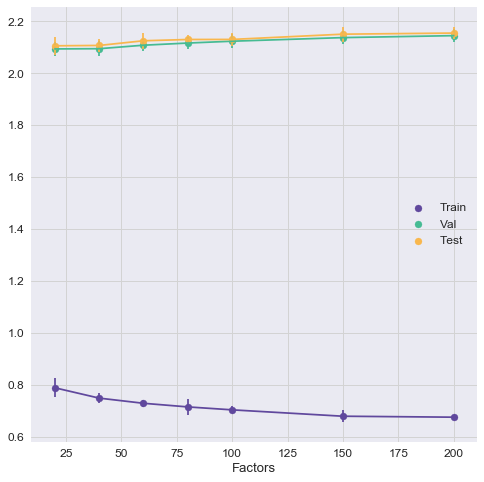

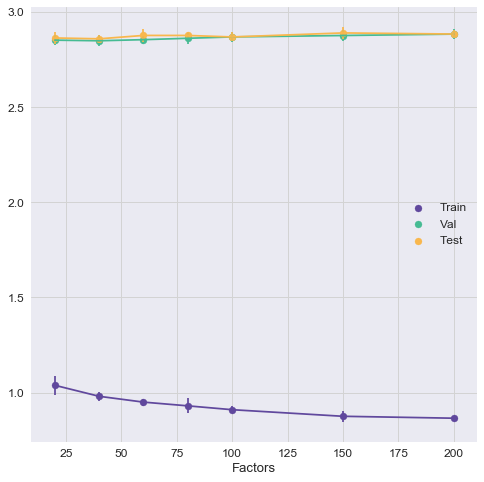

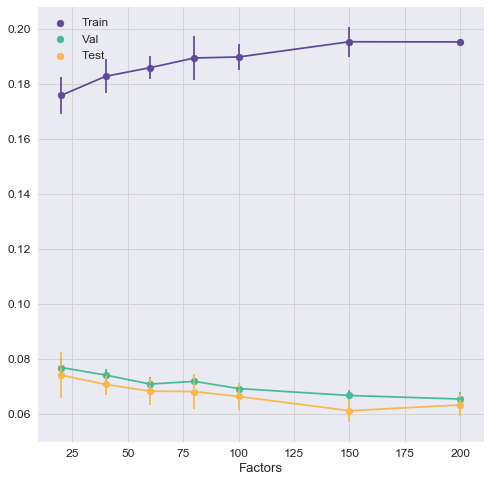

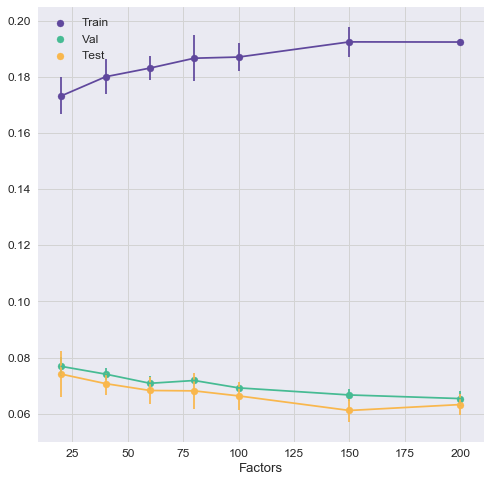

In [6]:
df_plot = df_eval.groupby(["n_factors"]).mean()
df_plot_std = df_eval.groupby(["n_factors"]).std()

for metric in ["mae", "rmse", "prec_at_" + str(k), "recall_at_" + str(k)]:
    fig, ax = plt.subplots(figsize=(8,8))
    for i, metric_set in enumerate(["train", "val", "test"]):
        ax.errorbar(df_plot.index, 
                    df_plot['_'.join([metric_set, metric])], 
                    df_plot_std['_'.join([metric_set, metric])],
                    color=second_palette[i])
        ax.scatter(df_plot.index, df_plot['_'.join([metric_set, metric])], 
                label=metric_set.title(), color=second_palette[i])

    ax.legend()
    ax.set_xlabel("Factors")
    ax.grid(True, color="lightgray")
    filename = "{}_factors_{}_folds.jpeg".format(metric, n_folds)
    fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

By leveraging all figures of merit, the number of factors to be chosen is $100$

In [25]:
n_factors = 100

### Top K Sweep

Now that we have established the number of factors, we can analyze how well the SVD performs in this algorithm for different recommendation ranks. 

In [7]:
%%time
n_folds = 5
ss = ShuffleSplit(n_splits=n_folds, train_size=.75, test_size=.2, random_state=0)
arr_k = np.arange(1, df_matrix.drop(["person"], axis=1).shape[1]+1, 1)
threshold = 7

df_eval = pd.DataFrame(columns=["k", "fold", 
                                "train_mae", "val_mae", "test_mae", 
                                "train_rmse", "val_rmse", "test_rmse",
                                "train_prec_at_k", "val_prec_at_k", "test_prec_at_k",
                                "train_recall_at_k", "val_recall_at_k", "test_recall_at_k"])

for k in arr_k:
    print ("Running analysis for k = {}".format(k))
    for fold, [train_index, val_index] in enumerate(ss.split(df_ratings.values)):
        print ("\tFold ", fold)
        
        train = df_ratings.iloc[train_index]
        val = df_ratings.iloc[val_index]
        test = df_ratings[~df_ratings.index.isin(np.concatenate([train_index, val_index]))]                
        
        svd = SVD(learning_rate=0.001, regularization=0.05, n_epochs=100, 
                  n_factors=n_factors, verbose=False)
        svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)
        
        train["prediction"] = svd.predict(train, clip=False)
        val["prediction"] = svd.predict(val, clip=False)
        test["prediction"] = svd.predict(test, clip=False)
        
        row = [
            k, fold, 
            utils.mean_absolute_error(train),
            utils.mean_absolute_error(val),
            utils.mean_absolute_error(test),
            utils.root_mean_squared_error(train),
            utils.root_mean_squared_error(val),
            utils.root_mean_squared_error(test),
            utils.precision_at_k(train, k, threshold),
            utils.precision_at_k(val, k, threshold),
            utils.precision_at_k(test, k, threshold),
            utils.recall_at_k(train, k, 7),
            utils.recall_at_k(val, k, 7),
            utils.recall_at_k(test, k, 7)
        ]
        
        df_eval.loc[df_eval.shape[0]] = row

Running analysis for k = 1
	Fold  0

Training took 1 sec


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 2
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 3
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 4
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 5
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 6
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1

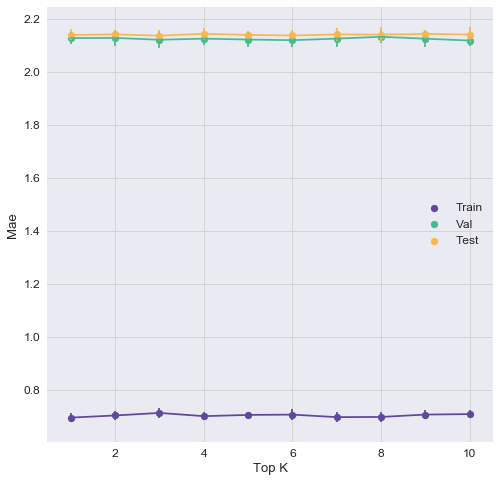

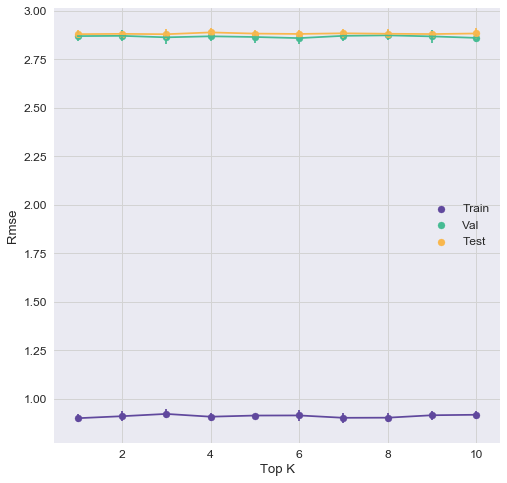

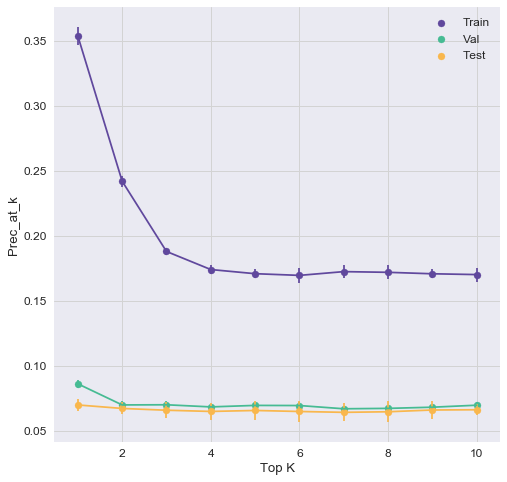

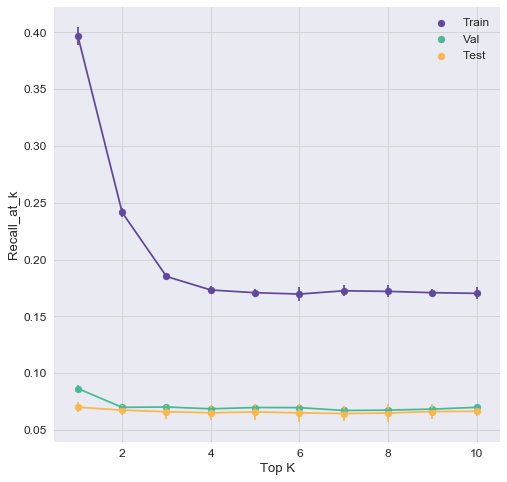

In [28]:
df_plot = df_eval.groupby(["k"]).mean()
df_plot_std = df_eval.groupby(["k"]).std()
for metric in ["mae", "rmse", "prec_at_k", "recall_at_k"]:
    fig, ax = plt.subplots(figsize=(8,8))
    for i, metric_set in enumerate(["train", "val", "test"]):
        ax.errorbar(df_plot.index, 
                    df_plot['_'.join([metric_set, metric])], 
                    df_plot_std['_'.join([metric_set, metric])],
                    color=second_palette[i])
        ax.scatter(df_plot.index, df_plot['_'.join([metric_set, metric])], 
                label=metric_set.title(), color=second_palette[i])

    ax.legend()
    ax.set_xlabel("Top K"), ax.set_ylabel(metric.capitalize())
    ax.grid(True, color="lightgray")
    filename = "{}_top_k_{}_folds.jpeg".format(metric, n_folds)
    fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

From the analysis above, we can check that RMSE and MAE are not greatly affected by ranking. This is expected since the number of recommended items are not taken into consideration for these prediction accuracy measures. 

However, we can see that the algorithm performs at its best for both Precision@k and Recall@k when $k = 1$. This leads to the conclusion that a short-term recommendation is suited for the algorithm, meaning it can predict which item shall be consumed next. 

In [10]:
# Extracting fully-densed utility matrix
df_matrix_original = svd.get_utility_matrix(df_ratings)

# Getting all u_id and i_id combinations
df_predictions= pd.melt(df_matrix_original.reset_index(drop=False), id_vars='u_id')
df_predictions.rename({"value": "rating"}, axis=1, inplace=True)

Prediction rewards for every possible user-item pair

In [12]:
df_predictions["rating"] = svd.predict(df_predictions, clip=False)
df_matrix_predictions = svd.get_utility_matrix(df_predictions)
df_matrix_predictions.to_csv(os.path.join(data_dir, "df_matrix_predictions.csv"), sep=';', index=None)

## 2. Clustering

Now that we have a fully densed utility matrix, we shall remember that most matrix factorization techniques require that users or items latent factors are trained. This is particularly inconvenient for new users or items, since their latent factors are unknown. 

In order to tackle this problem, we shall cluster users based on the fully-densed matrix. Once they are clustered, the centroid are used on the following MAB algorithm. 

In [29]:
# Including users' income as a clustering column
df_cluster = pd.merge(profile, df_matrix_predictions, how="inner", left_index=True, right_index=True)

Analyzing silhouette score for multiple number of clusters

In [24]:
silhouette_avg = list()
arr_n_clusters = np.arange(2, 20, 1)
X = df_cluster.values#.drop(["gender", "became_member_on", "days_since_subscription", "age", "gender_clean"], axis=1).values
df_silhouette_avg = pd.DataFrame(columns = ["fold", "n_cluster", "train_silhouette", "test_silhouette"])
trained_models = list()

for fold, [train_index, val_index] in enumerate(ss.split(X)):
    
    print ("Running analysis on fold {}".format(fold))
    X_train, X_val = X[train_index], X[val_index]
    
    for n_cluster in arr_n_clusters:        
        model = KMeans(n_clusters=n_cluster, random_state=0)
        
        model.fit(X_train)
        train_silhouette = silhouette_score(X_train, model.predict(X_train))
        val_silhouette = silhouette_score(X_val, model.predict(X_val))

        row = [fold, n_cluster, train_silhouette, val_silhouette]
        df_silhouette_avg.loc[df_silhouette_avg.shape[0]] = row   

Running analysis on fold 0
Running analysis on fold 1
Running analysis on fold 2
Running analysis on fold 3
Running analysis on fold 4


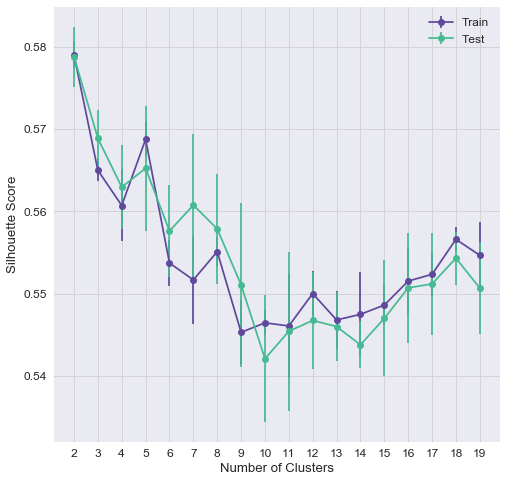

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
df_plot = df_silhouette_avg.groupby("n_cluster")
for i, set_label in enumerate(["train", "test"]):
    ax.errorbar(df_plot.mean().index, 
                df_plot.mean()[set_label + "_silhouette"].values, 
                df_plot.std()[set_label + "_silhouette"].values, label=set_label.title(),
               marker='o', mec='black', color = second_palette[i])
ax.set_xticks(arr_n_clusters), ax.set_xticklabels(arr_n_clusters)

ax.grid(True, color="lightgray")
ax.legend()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
filename = "silhouette_score.jpg"
fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

Considering the silhouette score, a proper number of clusters would be $5$

In [31]:
n_clusters = 5

In [32]:
model = KMeans(n_clusters=n_clusters, random_state=0)        
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [55]:
df_clusters_rewards = pd.DataFrame(model.cluster_centers_)
df_clusters_rewards.columns = df_cluster.columns
df_clusters_rewards = df_clusters_centers.reset_index(drop=False).rename({"index": "cluster"},axis=1).set_index("cluster")
df_clusters_rewards.drop(["income"], axis=1, inplace=True)
df_clusters_rewards.to_csv(os.path.join(data_dir, "df_clusters_rewards.csv"), sep=';')
df_clusters_rewards

,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
cluster,,,,,,,,,,
0,4.387408,4.371061,3.145145,1.157907,6.725339,1.156953,5.096065,7.192607,4.935809,3.857274
1,3.471464,3.881315,2.711263,1.141975,5.217324,1.142572,4.286186,5.627873,4.226337,3.437318
2,4.860903,4.601791,3.340910,1.163845,7.319904,1.162150,5.425436,7.863540,5.257803,4.047210
3,4.026415,4.181468,2.970414,1.151359,6.139243,1.150919,4.781541,6.558815,4.657121,3.693539
4,4.867360,4.602062,3.336457,1.164119,7.516154,1.163331,5.408824,7.743083,5.305740,4.062436


### Saving Models

In [53]:
joblib.dump(svd, os.path.join(data_dir, "trained_svd.joblib"))
joblib.dump(model, os.path.join(data_dir, "trained_kmeans.joblib"))

['./../data\\trained_svd.joblib']